In [2]:
%pip install -q diffusers transformers accelerate clip-interrogator 0.6.0

ERROR: Could not find a version that satisfies the requirement 0.6.0 (from versions: none)
ERROR: No matching distribution found for 0.6.0


In [3]:
%pip install rembg

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.12.3 requires grpcio>=1.48.2, but you have grpcio 1.47.5 which is incompatible.


In [4]:
import cv2
import json
import os
import torch
import glob
import numpy as np
from rembg import remove
from IPython.core.debugger import set_trace
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionImg2ImgPipeline
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from transformers import CLIPProcessor, CLIPModel
from clip_interrogator import Config, Interrogator
import nltk
# nltk.download('popular')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize ,  sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from collections import Counter

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2023-10-15 07:34:03.867838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
commandline_args = os.environ.get('COMMANDLINE_ARGS', "--skip-torch-cuda-test --no-half")

def extract_frames(video_path, output_path, frame_size):
    # Создаем папку для сохранения кадров, если она не существует
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Открываем видеофайл
    video = cv2.VideoCapture(video_path)
    success, image = video.read()
    count = 0
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))  # Получаем общую продолжительность видео
    step = int(video_length / 10)  # Вычисляем шаг для сохранения каждого 10% кадра

    while success:
        # Изменяем размер кадра
        resized_image = cv2.resize(image, frame_size)

        # Сохраняем кадр в файл, если count кратен шагу
        if count % step == 0:
            cv2.imwrite(f"{output_path}/frame{count}.jpg", resized_image)
        success, image = video.read()
        count += 1

    video.release()

# Пример использования функции
frame_size = (1280, 720)  # Размер кадров (ширина, высота)
for i in range(5):
  video_path = f"/home/jupyter/datasphere/Videos/{str(i)}.mp4"  # Путь к видеофайлу (загрузите видео в Google Colab)
  output_path = f"/home/jupyter/datasphere/Frames/class{str(i)}"  # Путь для сохранения кадров
  extract_frames(video_path, output_path, frame_size)


In [6]:
class ModelText2Image:
    def __init__(self):
        self.model_id = "stabilityai/stable-diffusion-2-1"
        self.model = self.build_model()        
    def build_model(self):
        pipe = StableDiffusionPipeline.from_pretrained(self.model_id, torch_dtype=torch.float32)
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
        self.model = pipe.to('cuda')
        return pipe
    


In [7]:
class ModelImage2Image:
    def __init__(self):
        self.model_id = "stabilityai/stable-diffusion-2-1"
        self.model = self.build_model()        
    def build_model(self):
        pipe = StableDiffusionImg2ImgPipeline.from_pretrained(self.model_id, torch_dtype=torch.float32)
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
        self.model = pipe.to('cuda')
        return pipe
    


In [8]:
modelText2Image = ModelText2Image().model

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
modelImage2Image = ModelImage2Image().model

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
# def create_noun_adjective_object(text):
#     # Инициализация лемматизатора WordNet
#     lemmatizer = WordNetLemmatizer()
    
#     # Токенизация текста на отдельные слова
#     tokens = word_tokenize(text)
    
#     # Частеречная разметка слов
#     tagged_words = pos_tag(tokens)
    
#     # Извлечение существительных и прилагательных
#     nouns = [word for word, pos in tagged_words if pos.startswith('NN')]
#     adjectives = [word for word, pos in tagged_words if pos.startswith('JJ')]
#     verbs = [word for word, pos in tagged_words if pos.startswith('VB')]
#     locations = [word for word, pos in tagged_words if pos.startswith('WP')]
    
#     # Лемматизация существительных и прилагательных
#     lemmatized_nouns = [lemmatizer.lemmatize(noun) for noun in nouns]
#     lemmatized_adjectives = [lemmatizer.lemmatize(adj) for adj in adjectives]
#     lemmatized_verbs = [lemmatizer.lemmatize(verb) for verb in verbs]
#     lemmatized_locs =  [lemmatizer.lemmatize(loca) for loca in locations]
    
#     # Исключение существительных, связанных с человеческим родом
#     excluded_nouns = ['person', 'people', 'man', 'woman','women','men',"child",'girl','boy']
#     filtered_nouns = [noun for noun in lemmatized_nouns if noun not in excluded_nouns]
    
#     # Создание связки существительного и прилагательного в объекте
#     objects = [adj + " " + noun + " " + verb + " " + loc for noun, adj, verb, loc in zip(filtered_nouns, lemmatized_adjectives, lemmatized_verbs, lemmatized_locs)]
    
#     return objects


def create_noun_adjective_object(text):
    # Инициализация лемматизатора WordNet
    lemmatizer = WordNetLemmatizer()

    # Токенизация текста на отдельные слова
    tokens = word_tokenize(text)

    # Частеречная разметка слов
    tagged_words = pos_tag(tokens)

    # Извлечение существительных и прилагательных
    nouns = [word for word, pos in tagged_words if pos.startswith('NN')]
    adjectives = [word for word, pos in tagged_words if pos.startswith('JJ')]

    # Лемматизация существительных и прилагательных
    lemmatized_nouns = [lemmatizer.lemmatize(noun) for noun in nouns]
    lemmatized_adjectives = [lemmatizer.lemmatize(adj) for adj in adjectives]

    # Исключение существительных, связанных с человеческим родом
    excluded_nouns = ['person', 'people', 'man', 'woman','human','men','women','child','girl','boy']
    filtered_nouns = [noun for noun in lemmatized_nouns if noun not in excluded_nouns]

    # Создание связки существительного и прилагательного в объекте
    objects = [noun + ' ' + adjective for noun in filtered_nouns for adjective in lemmatized_adjectives]

    return objects


In [11]:
listFrameHead = []
ci = Interrogator(Config(clip_model_name="ViT-L-14/openai"))
for i in range(2):
    folder_path = f"/home/jupyter/datasphere/Frames/class{i}/"
    image_paths = glob.glob(folder_path + '*.jpg')
    for path in image_paths:
        image = Image.open(path).convert("RGB")
        text = ci.interrogate(image)
        print(text)
        objects = create_noun_adjective_object(text)
        listFrameHead+=objects
print(listFrame)


Loading caption model blip-large...


Loading CLIP model ViT-L-14/openai...
Loaded CLIP model and data in 14.60 seconds.


Flavor chain:   3%|▎         | 1/32 [00:01<00:40,  1.32s/it]


KeyboardInterrupt: 

In [ ]:
listFrame = []
ci = Interrogator(Config(clip_model_name="ViT-L-14/openai"))
for i in range(1):
    folder_path = f"/home/jupyter/datasphere/Frames/class{i}/"
    image_paths = glob.glob(folder_path + '*.jpg')
    for path in image_paths:
        image = Image.open(path).convert("RGB")
        text = ci.interrogate(image)
        print(text)
        objects = create_noun_adjective_object(text)
        listFrame+=objects
print(listFrame)


Loading caption model blip-large...
Loading CLIP model ViT-L-14/openai...
Loaded CLIP model and data in 9.72 seconds.


100%|██████████| 50/50 [00:00<00:00, 181.63it/s]


there is a man that is playing a game of tennis, vhs artifacts, by Stanley Twardowicz, crashed, ƒ/3.5, grunge, teaser, a massive tornado approaching, disconnected, the 9 0 s, tvp


100%|██████████| 50/50 [00:00<00:00, 183.31it/s]


arafed image of a man in a pink shirt and sunglasses, unarmed combat, dmitry prozorov style, logo has”, volodymyr zelenskyy, animated episode still, twitch tv, lifting weights, inspired by Tahir Salahov, degradation, april, made in 2019, hirstute and muscled, easports


100%|██████████| 50/50 [00:00<00:00, 179.07it/s]


there is a man and a woman that are standing in the street, polovstian dances and chorus, yellow sport glasses, big booty, in deep forest hungle, cute sportswear, vdovenko, tvp, park in background, buttshape, chav, training, black and red jacket, dark taint :: athletic, blocks, 2 k


100%|██████████| 50/50 [00:00<00:00, 177.28it/s]


there is a man in a red shirt and sunglasses in a gym, video animation, nikolai karelin, red backwards cap, power pose, wearing human air force jumpsuit, snow on the body, wearing a grey hooded sweatshirt, 303, chad, comic strip style, f 3 5, chav, lifted, 3 1


100%|██████████| 50/50 [00:00<00:00, 180.12it/s]


there is a man drinking a bottle of soda in front of a whiteboard, bodybuilder ernest khalimov, wearing a school soccer uniform, wearing a red hoodie, marshal mathers, sport glasses, official music video, reagents, wearing school uniform, rap, drinking tea, necro, oil


100%|██████████| 50/50 [00:00<00:00, 180.33it/s]


there are two men standing in the woods talking to each other, performing a music video, russian style, rapping into microphone, wearing adidas clothing, petri rahkola, duckface, trio, red backwards cap, brown jacket, puṣkaracūḍa, prussia, crossbreed, 303


100%|██████████| 50/50 [00:00<00:00, 178.97it/s]


there are two men standing in a field with sunglasses on, rapping, inspired by Abram Arkhipov, wearing adidas clothing, forest in the background, nationalist, puṣkaracūḍa, vibrent red lipstick, retarded, wearing glack glasses, cascadia, rap, patriotism


100%|██████████| 50/50 [00:00<00:00, 179.27it/s]


there is a man standing in a field with his arms outstretched, zelensky having a tantrum, color correction, big sunglasses, red black white golden colors, rap, 3 are summer and 3 are autumn), 303, flying towards the camera, sweet home, 8 khd, tracksuit


100%|██████████| 50/50 [00:00<00:00, 62.57it/s] 

arafed suv parked in a field with a dog in the back, zelensky having a tantrum, wearing transparent glass mask, tv commercial, zdzidaw, faceless people, rap metal, canada, russian flag, passengers, wheelie, the window, mud, pyramid hoodvisor, windows



100%|██████████| 50/50 [00:00<00:00, 180.04it/s]


arafed man in a red jacket and sunglasses standing in a parking lot, space-station vuutun palaa, 2 0 1 5 live music video, chappie in an adidas track suit, promotional material, necro, inspired by Abram Arkhipov, autum, akseli gallen kallela, rasta, hcl, 3 d


100%|██████████| 50/50 [00:00<00:00, 154.24it/s]

a close up of a fire with lots of smoke and flames, still from a music video, hellfire background, scp-914, iconography background, inspired by Marina Abramović, standing in hell, hyperrealistic matte painting, sparse floating particles, scp-049, devil
['game massive', 'tennis massive', 'vhs massive', 'artifact massive', 'Stanley massive', 'Twardowicz massive', 'ƒ/3.5 massive', 'grunge massive', 'teaser massive', 'tornado massive', 'approaching massive', 's massive', 'tvp massive', 'image arafed', 'image unarmed', 'pink arafed', 'pink unarmed', 'shirt arafed', 'shirt unarmed', 'sunglass arafed', 'sunglass unarmed', 'combat arafed', 'combat unarmed', 'dmitry arafed', 'dmitry unarmed', 'prozorov arafed', 'prozorov unarmed', 'style arafed', 'style unarmed', 'logo arafed', 'logo unarmed', 'zelenskyy arafed', 'zelenskyy unarmed', 'episode arafed', 'episode unarmed', 'tv arafed', 'tv unarmed', 'weight arafed', 'weight unarmed', 'Tahir arafed', 'Tahir unarmed', 'Salahov arafed', 'Salahov unar

In [193]:
        from collections import defaultdict

        def sort_noun_adjective_objects(objects):
            # Создание словаря для подсчета частоты использования пар существительное + прилагательное
            frequency_dict = defaultdict(int)

            # Подсчет частоты использования пар существительное + прилагательное
            for obj in objects:
                noun, adjective = obj.split()
                frequency_dict[(noun, adjective)] += 1

            # Удаление повторяющихся слов
            unique_words = set()
            for noun, adjective in frequency_dict.keys():
                unique_words.add(noun)

            # Сортировка словаря по значениям в убывающем порядке
            sorted_dict = sorted(frequency_dict.items(), key=lambda x: x[1], reverse=True)

            # Создание нового списка с уникальными парами существительное + прилагательное
            unique_objects = []
            used_adjectives = set()
            for pair, _ in sorted_dict:
                noun, adjective = pair
                if noun in unique_words and adjective not in used_adjectives:
                    unique_objects.append(' '.join(pair))
                    used_adjectives.add(adjective)

            return unique_objects

# from collections import defaultdict

# def sort_noun_adjective_objects(objects):
#     # Создание словаря для подсчета частоты использования пар существительное + прилагательное
#     frequency_dict = defaultdict(int)

#     # Подсчет частоты использования пар существительное + прилагательное
#     for obj in objects:
#         noun, adjective = obj.split()
#         frequency_dict[(noun, adjective)] += 1

#     # Удаление повторяющихся слов
#     unique_words = set()
#     unique_objects = []
#     used_adjectives = set()
#     for pair, _ in frequency_dict.items():
#         noun, adjective = pair
#         if noun not in unique_words and adjective not in used_adjectives:
#             unique_words.add(noun)
#             unique_objects.append(' '.join(pair))
#             used_adjectives.add(adjective)

#     return unique_objects


In [194]:
sorted_list = sort_noun_adjective_objects(listFrame)
sorted_listHead = sort_noun_adjective_objects(listFrameHead)

In [195]:
print(sorted_list)
print()
print()
print(sorted_listHead)

['video red', 'tv arafed', 'school ernest', 'school marshal', 'school official', 'color big', 'color black', 'color white', 'color golden', 'color sweet', 'window transparent', 'window commercial', 'window zdzidaw', 'window faceless', 'window russian', 'background close', 'background scp-914', 'background hyperrealistic', 'background scp-049', 'background devil', 'game massive', 'image unarmed', 'street polovstian', 'street yellow', 'street deep', 'street cute', 'street dark', 'street athletic', 'shirt nikolai', 'shirt human', 'shirt comic', 'wood other', 'wood brown', 'field forest', 'jacket live', 'jacket adidas', 'jacket promotional', 'jacket akseli']


['jacket red', 'suit adidas', 'image arafed', 'gym yellow', 'style russian', 'background sweaty', 'sportswear cute', 'jacket athletic', 'sunglass human', 'front official', 'school ernest', 'school marshal', 'color big', 'color black', 'color white', 'color golden', 'flame scp-914', 'background close', 'background hyperrealistic', 'ba

In [196]:
testValues = ' video background '
testValues += ';'.join(sorted_list[:10])
# testValues += ';(((human:1.3)))'
print(testValues)
testValuesHead = ' video background '
testValuesHead += ';'.join(sorted_listHead[:10])
print(testValuesHead)

 video background video red;tv arafed;school ernest;school marshal;school official;color big;color black;color white;color golden;color sweet
 video background jacket red;suit adidas;image arafed;gym yellow;style russian;background sweaty;sportswear cute;jacket athletic;sunglass human;front official


In [16]:
class ImageDisplay:
  def showI(image):
    plt.axis("off")
    plt.imshow(image)
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

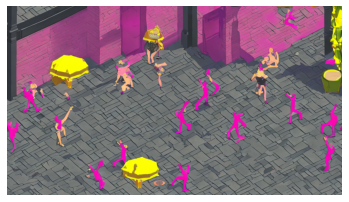

In [ ]:
# for i in modelText2Image((testValues),
#            num_inference_steps=200,
#            # num_images_per_prompt=int(input("Count: ")),
#            height=720, width=1280).images:
#   ImageDisplay.showI(i)

In [197]:
a = modelText2Image((testValues), num_inference_steps=200, height=720, width=1280).images
a[0].save("/home/jupyter/datasphere/Preview/preview.png")

  0%|          | 0/200 [00:00<?, ?it/s]

In [210]:
def adjust_dimensions(height, width):
    new_height = (height + 7) // 8 * 8
    new_width = (width + 7) // 8 * 8
    return new_height, new_width

height = 864
width = 2204

new_height, new_width = adjust_dimensions(height, width)

a = modelText2Image((testValuesHead), num_inference_steps=200, new_height, new_width).images
a[0].save("/home/jupyter/datasphere/Preview/previewHead.png")

SyntaxError: positional argument follows keyword argument (<ipython-input-210-3709657233d5>, line 11)

In [211]:
a = modelText2Image((testValuesHead), num_inference_steps=200, height=800, width=800).images
a[0].save("/home/jupyter/datasphere/Preview/previewAvatar.png")

  0%|          | 0/200 [00:00<?, ?it/s]

In [213]:
input_path = '/home/jupyter/datasphere/Face/Input/face.jpg'
output_path = '/home/jupyter/datasphere/Face/Output/face.jpg'

with open(input_path, 'rb') as inp:
    with open(output_path, 'wb') as out:
        inputx = inp.read()
        output = remove(inputx)
        out.write(output)


In [14]:
img = Image.new('RGB', (1280, 720))
img1 = Image.open("/home/jupyter/datasphere/Preview/preview.png")
img.paste(img1)
img2 = Image.open('/home/jupyter/datasphere/Face/Output/face.jpg')
img.paste(img2, (0,0), img2)
img.save("/home/jupyter/datasphere/Preview/preview_update.png")

In [33]:
# Add Text to an image

I1 = ImageDraw.Draw(img)
fonts = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 48)

txt = "Пользователь не хочет текста"
text = ""
j = 0
for i in txt:
  if j<=29:
    text+=i
    j+=1
  else:
    text+="\n"+i
    j=0
# text = "".join(i for i in txt if j <= 30) + "\n" + "".join(i for i in txt if j > 30)


I1.text((1290-1280/1, 720-720/4),text, font=fonts, fill=(0, 255, 0), stroke_width = 1, stroke_fill =(0, 0, 0) )

class ModelImage2Image:
    def __init__(self):
        self.model_id = "stabilityai/stable-diffusion-2-1"
        self.model = self.build_model()        
    def build_model(self):
        pipe = StableDiffusionImg2ImgPipeline.from_pretrained(self.model_id, torch_dtype=torch.float32)
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
        self.model = pipe.to('cuda')
        return pipe
img.save("/home/jupyter/datasphere/Preview/preview_updateFont.png")
z = input("Пользователь:");
model = ModelImage2Image().build_model();
a = model((h),img, num_inference_steps=200).images

ImageDisplay.showI(a)
# for i in model((z,img,num_inference_steps=200,).images[0]:
#     ImageDisplay.showI(i)

Пользователь: стиль святого патрика


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
Стиль святого патрика